<a href="https://colab.research.google.com/github/intel-analytics/Chronos-workshop/blob/main/notebook/chronos_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

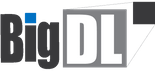

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[pytorch,distributed]`.

- We use pytorch as backend here, while chronos also support tensorflow as well.
- We will install both single node and cluster support here. Although we only have a single node on colab, we may show distributed workload on local mode.

In [ ]:
print("This block is designed to exit(crash) for refreshing installed pkg.")

!pip install --pre --upgrade bigdl-chronos[pytorch,distributed] # Install latest pre-release version of bigdl-chronos
!pip uninstall -y torchtext  # uninstall torchtext to avoid version conflict

# acclerators
!pip install onnx, onnxruntime
!pip install openvino-dev

# for quantization
!pip install neural-compressor==1.11  # install INC for quantization
!pip install opencv-python-headless==4.1.2.30  # change opencv to avoid version conflict

exit() # restart the runtime to refresh installed pkg

## **Step 0: Prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [1]:
from bigdl.chronos.data.repo_dataset import get_public_dataset

tsdata_train, tsdata_valid, tsdata_test = get_public_dataset("nyc_taxi")

## **Time series forecasting using Chronos Forecaster**

### Forecaster Step1. Data transformation and feature engineering using Chronos TSDataset 
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

Preprocess the datasets. Here we perform:
- deduplicate: remove those identical data records
- impute: fill the missing values
- gen_dt_feature: generate feature from datetime (e.g. month, day...)
- scale: scale each feature to standard distribution.
- roll: sample the data with sliding window.

For forecasting task, we will look back 3 hours' historical data (6 records) and predict the value of next 30 miniutes (1 records).

We perform the same transformation processes on train, valid and test set.

In [2]:
from sklearn.preprocessing import StandardScaler

past_seq_len, future_seq_len = 96, 1

scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
    tsdata.impute()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=past_seq_len, horizon=future_seq_len)

### Forecaster Step 2: Time series forecasting using Chronos Forecaster
After preprocessing the datasets. We can use [Chronos Forecaster](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html) to handle the forecasting tasks.

In [5]:
from bigdl.chronos.forecaster import TCNForecaster

forecaster = TCNForecaster.from_tsdataset(tsdata_train, num_channels=[16]*3)
forecaster.fit(tsdata_train)

Global seed set to 3333094
/home/junweid/BigDL/python/chronos/src/bigdl/chronos/forecaster/base_forecaster.py:80: UserWarning: HPO is enabled but no spaces is specified, so disable HPO.
  warnings.warn("HPO is enabled but no spaces is specified, so disable HPO.")
Global seed set to 3333094
/home/junweid/BigDL/python/chronos/src/bigdl/chronos/forecaster/base_forecaster.py:346: UserWarning: Data shape checking is not supported by dataloader input.
  warnings.warn("Data shape checking is not supported by dataloader input.")
/home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: False
TPU available: False, using:

Training: 0it [00:00, ?it/s]

### Forecaster Step 3: Evaluate your fitted forecaster
Use fitted forecaster to predict test data and plot the result

In [6]:
x_test, y_test = tsdata_test.to_numpy()
pred = forecaster.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)

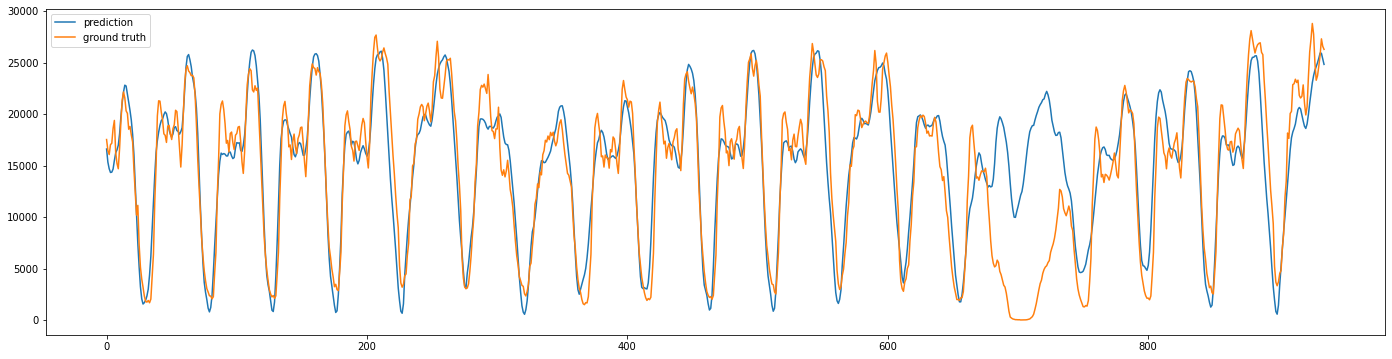

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.plot(pred_unscale[:,:,0])
plt.plot(groundtruth_unscale[:,:,0])
plt.legend(["prediction", "ground truth"])

### Forecaster Step 4: Further Optimize my forecaster

#### Use some accelerators for inferencing

Accelerate my forecaster! That's a normal request from many of our customers. One way to do this is to adopt some accelerator such as:

- onnxruntime: an accelerator provided by Microsoft on onnx structure.
- openvino: an inference engine provided by Intel

Adopting them in Chronos is super easy, just call `predict_with_onnx` and `predict_with_openvino`, the forecaster abstraction will hide all the complex calling for our users.

In [8]:
pred_onnxruntime = forecaster.predict_with_onnx(x_test)
pred_openvino = forecaster.predict_with_openvino(x_test)

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/tmp/tmpv32th3vb/tmp.onnx
	- Path for generated IR: 	/tmp/tmpq8i7tc9m
	- IR output name: 	tmp
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Frontend of Model Optimizer for 

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


In [9]:
from bigdl.chronos.metric.forecast_metrics import Evaluator

def func_original():
    forecaster.predict(x_test[0:1, :, :])
def func_onnxruntime():
    forecaster.predict_with_onnx(x_test[0:1, :, :])
def func_openvino():
    forecaster.predict_with_openvino(x_test[0:1, :, :])

print("original pytorch runtime (ms):", Evaluator.get_latency(func_original))
print("use accelerator (onnxruntime) (ms):", Evaluator.get_latency(func_onnxruntime))
print("use accelerator (openvino) (ms):", Evaluator.get_latency(func_openvino))

original pytorch runtime (ms): {'p50': 0.396, 'p90': 0.57, 'p95': 0.757, 'p99': 1.654}
use accelerator (onnxruntime) (ms): {'p50': 0.046, 'p90': 0.049, 'p95': 0.053, 'p99': 0.281}
use accelerator (openvino) (ms): {'p50': 0.178, 'p90': 0.188, 'p95': 0.201, 'p99': 1.426}


#### Quantize my forecaster

Quantization has become more and more important in model serving and edge environment, since it can help you

- improve inference throughput and latency
- shrink the forecaster's size

In Chronos forecaster, `forecaster.quantize` will call Intel Neural Compressor and hide the complex setting to our users.

In [10]:
forecaster.quantize(tsdata_train.to_numpy())

2022-08-21 13:20:59 [INFO] Generate a fake evaluation function.
2022-08-21 13:20:59 [INFO] Pass query framework capability elapsed time: 34.51 ms
2022-08-21 13:20:59 [INFO] Get FP32 model baseline.
2022-08-21 13:20:59 [INFO] Save tuning history to /home/junweid/Chronos-workshop/notebook/nc_workspace/2022-08-21_13-20-58/./history.snapshot.
2022-08-21 13:20:59 [INFO] FP32 baseline is: [Accuracy: 1.0000, Duration (seconds): 0.0000]
2022-08-21 13:20:59 [INFO] |********Mixed Precision Statistics*******|
2022-08-21 13:20:59 [INFO] +------------------------+--------+-------+
2022-08-21 13:20:59 [INFO] |        Op Type         | Total  |  INT8 |
2022-08-21 13:20:59 [INFO] +------------------------+--------+-------+
2022-08-21 13:20:59 [INFO] |  quantize_per_tensor   |   9    |   9   |
2022-08-21 13:20:59 [INFO] |        permute         |   2    |   2   |
2022-08-21 13:20:59 [INFO] |       ConvReLU1d       |   8    |   8   |
2022-08-21 13:20:59 [INFO] |        Dropout         |   8    |   8   |

### Forecaster Step 5: Save my forecaster

You may save & restore the (non-quantized & quantized) forecaster.

In [15]:
forecaster.save("nyc_taxi.fxt", "nyc_taxi_q.fxt")
forecaster.load("nyc_taxi.fxt", "nyc_taxi_q.fxt")

2022-08-21 11:32:49 [INFO] Save config file and weights of quantized model to /home/junweid/Chronos-workshop/notebook/nyc_taxi_q.fxt.
Global seed set to 4069044781
2022-08-21 11:32:49 [WARNING] /home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 5 simple steps.

### AutoTS Step 1: Init Orca Context

In [17]:
# import necessary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [18]:
init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/home/junweid/miniconda3/envs/chronos/lib/python3.7/site-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar pyspark-shell 
[main] WARN  org.apache.spark.util.Utils  - Your hostname, junweid-LEGION-REN7000K-26IAB resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface enp4s0)
[main] WARN  org.apache.spark.util.Utils  - Set SPARK_LOCAL_IP if you need to bind to another address
[main] WARN  org.apache.hadoop.util.NativeCodeLoader  - Una

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-08-21 12:31:14,335 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-08-21 12:31:14,337 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-08-21 12:31:14,337 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-08-21 12:31:14,337 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-08-21 12:31:14 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-08-21 12:31:14 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 4



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

22-08-21 12:31:14 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 24
[Thread-4] WARN  org.apache.spark.SparkContext  - Using an existing SparkContext; some configuration may not take effect.
22-08-21 12:31:14 [Thread-4] INFO  Engine$:456 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity
Successfully got a SparkContext


2022-08-21 12:31:16,907	INFO services.py:1340 -- View the Ray dashboard at http://10.97.0.6:8265


{'node_ip_address': '10.97.0.6', 'raylet_ip_address': '10.97.0.6', 'redis_address': '10.97.0.6:6379', 'object_store_address': '/tmp/ray/session_2022-08-21_12-31-14_981168_9243/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-21_12-31-14_981168_9243/sockets/raylet', 'webui_url': '10.97.0.6:8265', 'session_dir': '/tmp/ray/session_2022-08-21_12-31-14_981168_9243', 'metrics_export_port': 63779, 'node_id': 'fec96f251aa8bf1847f067afb0640bd18598caeb5820e546c8525a71'}


<SparkContext master=local[4] appName=pyspark-shell>

2022-08-21 12:32:21,715	WARNING worker.py:1245 -- (ip=10.97.0.6) The agent on node junweid-LEGION-REN7000K-26IAB failed to be restarted 5 times. There are 3 possible problems if you see this error.
  1. The dashboard might not display correct information on this node.
  2. Metrics on this node won't be reported.
  3. runtime_env APIs won't work.
Check out the `dashboard_agent.log` to see the detailed failure messages.


### AutoTS Step 2: Data transformation and feature engineering using Chronos TSDataset
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [19]:
tsdata_train, tsdata_val, tsdata_test = get_public_dataset("nyc_taxi")

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

### AutoTS Step 3: Create an AutoTSEstimator


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [20]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='tcn', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(48, 96)) # hp sampling function of past_seq_len for auto-tuning

### AutoTS Step 4: Fit with AutoTSEstimator

In [21]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

2022-08-21 12:33:41,661	WARNING function_runner.py:562 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-08-21 12:33:41,734	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features
train_func_6f2fc_00000,RUNNING,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']"
train_func_6f2fc_00001,PENDING,,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']"
train_func_6f2fc_00002,PENDING,,0.00670263,3,8,0.00869807,16,71,['WEEKDAY']
train_func_6f2fc_00003,PENDING,,0.0436741,5,8,0.00390264,16,60,[]
train_func_6f2fc_00004,PENDING,,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']"
train_func_6f2fc_00005,PENDING,,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']"
train_func_6f2fc_00006,PENDING,,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']"
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']"
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']"
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']"


(ImplicitFunc pid=12975) Global seed set to 4069044781
(ImplicitFunc pid=12974) Global seed set to 4069044781
(ImplicitFunc pid=12972) Global seed set to 4069044781
(ImplicitFunc pid=12973) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00000,RUNNING,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",1,2.16569,0.139793,0.139793
train_func_6f2fc_00001,RUNNING,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",,,,
train_func_6f2fc_00002,RUNNING,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],,,,
train_func_6f2fc_00003,RUNNING,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],,,,
train_func_6f2fc_00004,PENDING,,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",,,,
train_func_6f2fc_00005,PENDING,,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",,,,
train_func_6f2fc_00006,PENDING,,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00000,RUNNING,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",4,8.3973,0.0485239,0.0485239
train_func_6f2fc_00001,RUNNING,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",2,6.41561,0.347525,0.347525
train_func_6f2fc_00002,RUNNING,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],2,7.63797,0.979316,0.979316
train_func_6f2fc_00003,RUNNING,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],1,5.50142,0.21009,0.21009
train_func_6f2fc_00004,PENDING,,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",,,,
train_func_6f2fc_00005,PENDING,,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",,,,
train_func_6f2fc_00006,PENDING,,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,


(ImplicitFunc pid=12975) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00001,RUNNING,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",4,12.7972,0.319985,0.319985
train_func_6f2fc_00002,RUNNING,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],3,11.4222,0.979316,1.02486
train_func_6f2fc_00003,RUNNING,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],2,10.7906,0.21009,0.211812
train_func_6f2fc_00004,RUNNING,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",,,,
train_func_6f2fc_00005,PENDING,,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",,,,
train_func_6f2fc_00006,PENDING,,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,


(ImplicitFunc pid=12974) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00003,RUNNING,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],3,16.1019,0.0711555,0.0711555
train_func_6f2fc_00004,RUNNING,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",2,8.81634,0.203561,0.203561
train_func_6f2fc_00005,RUNNING,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",,,,
train_func_6f2fc_00006,PENDING,,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995


(ImplicitFunc pid=12973) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00003,RUNNING,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],4,21.4551,0.0689196,0.0689196
train_func_6f2fc_00004,RUNNING,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",3,13.2428,0.143313,0.143313
train_func_6f2fc_00005,RUNNING,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",1,5.77669,0.214333,0.214333
train_func_6f2fc_00006,RUNNING,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00007,PENDING,,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995


(ImplicitFunc pid=12972) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00004,RUNNING,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",4,17.6583,0.12873,0.12873
train_func_6f2fc_00005,RUNNING,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",2,11.5637,0.085437,0.085437
train_func_6f2fc_00006,RUNNING,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",1,6.37769,0.201712,0.201712
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,PENDING,,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866


(ImplicitFunc pid=12975) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00005,RUNNING,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",3,17.3358,0.085437,0.0880997
train_func_6f2fc_00006,RUNNING,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",2,12.8,0.127164,0.127164
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",,,,
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",,,,
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00005,RUNNING,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",4,23.2279,0.076712,0.076712
train_func_6f2fc_00006,RUNNING,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",3,19.2839,0.0874685,0.0874685
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",1,12.9261,0.996719,0.996719
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",1,7.61561,0.333693,0.333693
train_func_6f2fc_00009,PENDING,,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016


(ImplicitFunc pid=12974) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00006,RUNNING,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",4,25.6884,0.0797509,0.0797509
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",1,12.9261,0.996719,0.996719
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",2,15.2023,0.190772,0.190772
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,PENDING,,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189


(ImplicitFunc pid=12973) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",1,12.9261,0.996719,0.996719
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",2,15.2023,0.190772,0.190772
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",,,,
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",2,25.89,0.991952,0.991952
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",3,22.832,0.163029,0.163029
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",1,10.3762,1.00682,1.00682
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",2,25.89,0.991952,0.991952
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",4,30.559,0.134,0.134
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",1,10.3762,1.00682,1.00682
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",,,,
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",3,38.9541,0.991952,1.00296
train_func_6f2fc_00008,RUNNING,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",4,30.559,0.134,0.134
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",2,20.7358,1.00682,1.00963
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",1,12.2286,0.126696,0.126696
train_func_6f2fc_00011,PENDING,,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671


(ImplicitFunc pid=12975) Global seed set to 4069044781


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",3,38.9541,0.991952,1.00296
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",2,20.7358,1.00682,1.00963
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",1,12.2286,0.126696,0.126696
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",4,52.0457,0.971023,0.971023
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",3,31.1477,0.93883,0.93883
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",2,24.3101,0.0692185,0.0692185
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",4,52.0457,0.971023,0.971023
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",3,31.1477,0.93883,0.93883
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",2,24.3101,0.0692185,0.0692185
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",,,,
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00007,RUNNING,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",4,52.0457,0.971023,0.971023
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",4,41.7239,0.93883,1.00386
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",3,36.4011,0.0689373,0.0689373
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",1,18.6628,0.984747,0.984747
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00009,RUNNING,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",4,41.7239,0.93883,1.00386
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",3,36.4011,0.0689373,0.0689373
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",1,18.6628,0.984747,0.984747
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",4,48.2018,0.0510179,0.0510179
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",1,18.6628,0.984747,0.984747
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00010,RUNNING,10.97.0.6:12973,0.141099,3,8,0.00652798,48,73,"['DAY', 'YEAR', 'MONTH']",4,48.2018,0.0510179,0.0510179
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",2,36.6235,0.977946,0.977946
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",2,36.6235,0.977946,0.977946
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",2,36.6235,0.977946,0.977946
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",2,36.6235,0.977946,0.977946
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",3,53.6777,0.972787,0.972787
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",3,53.6777,0.972787,0.972787
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",3,53.6777,0.972787,0.972787
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",4,70.8669,0.969868,0.969868
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",4,70.8669,0.969868,0.969868
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",4,70.8669,0.969868,0.969868
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00011,RUNNING,10.97.0.6:12975,0.0139985,5,8,0.00529569,48,57,"['WEEKOFYEAR', 'DAY', 'MONTH', 'DAYOFYEAR', 'WEEKDAY', 'IS_WEEKEND']",4,70.8669,0.969868,0.969868
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266


Trial name,status,loc,dropout,kernel_size,levels,lr,nhid,past_seq_len,selected_features,iter,total time (s),best_mse,mse
train_func_6f2fc_00000,TERMINATED,10.97.0.6:12975,0.0356051,3,6,0.00396538,16,50,"['WEEKOFYEAR', 'YEAR']",5,10.4607,0.0485239,0.056995
train_func_6f2fc_00001,TERMINATED,10.97.0.6:12974,0.191111,5,6,0.00188507,16,69,"['MONTH', 'WEEKOFYEAR', 'YEAR', 'DAYOFYEAR', 'WEEKDAY']",5,16.0062,0.319985,0.32866
train_func_6f2fc_00002,TERMINATED,10.97.0.6:12973,0.00670263,3,8,0.00869807,16,71,['WEEKDAY'],5,19.0892,0.972016,0.972016
train_func_6f2fc_00003,TERMINATED,10.97.0.6:12972,0.0436741,5,8,0.00390264,16,60,[],5,26.7744,0.0664189,0.0664189
train_func_6f2fc_00004,TERMINATED,10.97.0.6:12975,0.197639,3,6,0.00380777,32,71,"['IS_WEEKEND', 'DAYOFYEAR', 'YEAR', 'DAY', 'WEEKDAY']",5,22.1034,0.121671,0.121671
train_func_6f2fc_00005,TERMINATED,10.97.0.6:12974,0.13184,5,6,0.00672905,32,59,"['DAY', 'MONTH', 'WEEKOFYEAR']",5,29.0783,0.076712,0.085145
train_func_6f2fc_00006,TERMINATED,10.97.0.6:12973,0.16473,3,8,0.00161779,32,50,"['DAY', 'DAYOFYEAR', 'IS_WEEKEND', 'YEAR', 'WEEKOFYEAR', 'MONTH']",5,32.1381,0.0797509,0.0896028
train_func_6f2fc_00007,TERMINATED,10.97.0.6:12972,0.0966243,5,8,0.00830881,32,84,"['YEAR', 'WEEKOFYEAR', 'MONTH']",5,65.1524,0.971023,1.04021
train_func_6f2fc_00008,TERMINATED,10.97.0.6:12975,0.176561,3,6,0.00212739,48,81,"['WEEKDAY', 'DAY']",5,38.2461,0.0992266,0.0992266
train_func_6f2fc_00009,TERMINATED,10.97.0.6:12974,0.0854147,5,6,0.00873935,48,72,"['YEAR', 'DAY', 'WEEKDAY', 'MONTH']",5,52.0604,0.93883,0.969703


2022-08-21 12:36:21,686	INFO tune.py:626 -- Total run time: 160.04 seconds (159.84 seconds for the tuning loop).
Global seed set to 4069044781
Global seed set to 4069044781


### AutoTS Step 5: Further deployment with TSPipeline

[TSPipeline](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline) is our E2E solution for time series forecasting task.

In [22]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

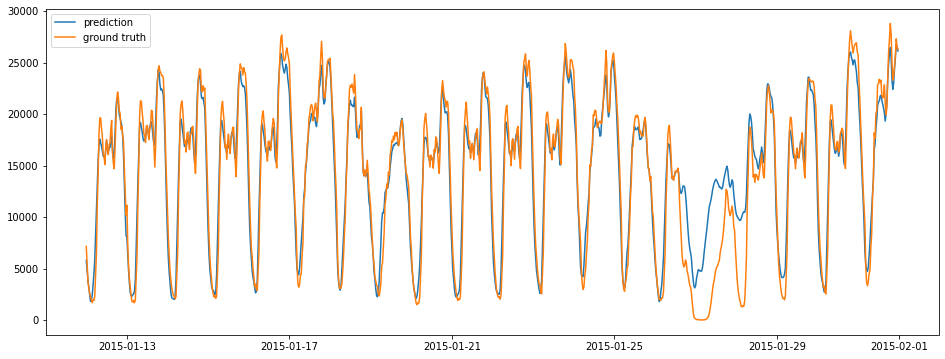

In [24]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(16,6))
plt.plot(groundtruth_unscale["timestamp"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["timestamp"], groundtruth_unscale["value"])
plt.legend(["prediction", "ground truth"])

In [25]:
# save the pipeline
my_ppl_file_path = "/tmp/saved_pipeline"
ts_pipeline.save(my_ppl_file_path)

In [26]:
# restore the pipeline for further deployment
from bigdl.chronos.autots import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

Global seed set to 4069044781


In [ ]:
# Stop orca context when your program finishes
stop_orca_context()

In [ ]:
# show a tensorboard view
%load_ext tensorboard
%tensorboard --logdir /tmp/autots_estimator/autots_estimator_leaderboard/